[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ducis28/sg-dlfs4/blob/main/dlfs4_ch07.ipynb)

# 『ゼロから作るDeep Learning ❹ 強化学習編』

https://github.com/oreilly-japan/deep-learning-from-scratch-4

## 第7章 ニューラルネットワークと Q 学習

これまで小さな問題（状態，行動の候補が少ない）を扱ってきた。小さな問題の Q 関数はテーブルで表現できるが，大きな問題ではそうはいかない。

たとえばチェスのように状態（コマの並びのパターン）が $10^{123}$ 通り存在するような場合，このように巨大なサイズのテーブルを保持したり，そのテーブルの各要素を独立して評価・改善するのは現実的ではない。

この問題を解決する方法として，Q 関数をコンパクトな関数で近似することが考えられる。その有力な手法が深層学習である。

本章では， DeZero という深層学習フレームワークの使い方を学び，ニューラルネットワークの基礎を学ぶ。その後，前章で実装した Q 学習を今度は NN で実装する。

### 7.1 DeZero の基礎

- https://github.com/oreilly-japan/deep-learning-from-scratch-3 GitHub サポートページ
- https://pypi.org/project/dezero/ dezero -- PyPI
- https://koki0702.github.io/dezero-book/ DeZero Book 「ゼロから作るDeep Learning ❸」オンラインブック
- https://www.oreilly.co.jp/books/9784873119069/ オライリー社『ゼロから作るDeep Learning ❸―フレームワーク編』

dezero と PyTorch は書き方が似ているため，書き換えが容易（なはず）。

#### 7.1.1 DeZeroを使う

In [ ]:
!pip install dezero

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install dezerogym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
### numpy + dezero

import numpy as np
from dezero import Variable

x_np = np.array(5.0)
x = Variable(x_np)

y = 3 * x ** 2

print('y =', y)

print('x.grad =', x.grad)

y.backward()

print('x.grad =', x.grad)

y = variable(75.0)
x.grad = None
x.grad = variable(30.0)


In [ ]:
### numpy + pytorch (?)

import torch
from torch import Tensor
from torch.autograd import Variable

#x_tensor = Tensor([5.0])
#x = Variable(x_tensor, requires_grad=True)
x = torch.tensor(5.0, requires_grad=True)

y = 3 * x ** 2

print('y =', y)

print('x.grad =', x.grad)

y.backward()

print('x.grad =', x.grad)

y = tensor(75., grad_fn=<MulBackward0>)
x.grad = None
x.grad = tensor(30.)


上のコードでおこなっているのは以下のような関数とその微分係数の計算である。

$y = 3 x^2$ とおくと，

$x = 5$ のとき $y = 3 \cdot 5^2 = 75$ であり，

その微分 $\frac{dy}{dx}=6x$ は $x=5$ のとき $6 \cdot 5 = 30$ である。

関数グラフに対する誤差逆伝播（バックプロパゲーション）によって微分を求めている。

#### 7.1.2 多次元配列（テンソル）と関数

- 0 次元配列 = スカラ
- 1 次元配列 = ベクトル
- 2 次元配列 = 行列

これらを含む $d$ 次元配列（$d=0,1,2,\cdots$）を多次元配列とよぶ。

$d$ 次元配列を $d$ 階テンソルともよぶ。

In [ ]:
# dezero 版

import numpy as np
from dezero import Variable
import dezero.functions as F

# Inner products
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
a, b = Variable(a), Variable(b)  # Optional
c = F.matmul(a, b)
print(c)

# Matrix product
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6], [7, 8]])
c = F.matmul(a, b)
print(c)

variable(32)
variable([[19 22]
          [43 50]])


In [ ]:
# PyTorch 版

import torch

# Inner products
a = torch.tensor([1, 2, 3])
b = torch.tensor([4, 5, 6])
c = torch.matmul(a, b)
print(c)

# Matrix product
a = torch.tensor([[1, 2], [3, 4]])
b = torch.tensor([[5, 6], [7, 8]])
c = torch.matmul(a, b)
print(c)

tensor(32)
tensor([[19, 22],
        [43, 50]])


#### 7.1.3 最適化

ローゼンブロック関数

$$
y=100(x_1-x_0^2)^2+(x_0-1)^2
$$

明らかに $(x_0,x_1)=(1,1)$ のときに最小値 $y=0$ をとる。

まず $(x_0,x_1)=(0.0,2.0)$ において，ローゼンブロック関数の微分係数を求める。

$$
\begin{align*}
\frac{\partial y}{\partial x_0}
&=
200(x_1-x_0^2)(-2x_0)+2(x_0-1)
\\
\frac{\partial y}{\partial x_1}
&=
200(x_1-x_0^2)
\end{align*}
$$

In [ ]:
import numpy as np
from dezero import Variable

def rosenbrock(x0, x1):
    y = 100 * (x1 - x0 ** 2) ** 2 + (x0 - 1) ** 2
    return y

x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))

y = rosenbrock(x0, x1)
y.backward()
print(x0.grad, x1.grad)

variable(-2.0) variable(400.0)


$(x_0,x_1)=(0,2)$ における勾配は $\nabla y=(-2,400)$ である。

勾配は関数を増やす方向であるから，
ローゼンブロック関数の最小値を求めるためには，
勾配とは逆向きに進めばよい。

学習率を $\gamma=0.001$ とすると，
$(x_0,x_1)$ の値は $(0,2)-\gamma\cdot\nabla y(0,2)=(0.002,1.6)$ に更新される。

この更新を繰り返し実施するのが **勾配降下法（Gradient Descent）** である。

勾配降下法をプログラムで実装する。

In [ ]:
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))

lr = 0.001     # 学習率
iters = 10000  # 繰り返す回数

for i in range(iters):
    if i % 1000 == 0:
        print(i, x0, x1)
    y = rosenbrock(x0, x1)

    x0.cleargrad()
    x1.cleargrad()
    y.backward()

    # 【注意】更新は x0 でなく x0.data に対しておこなう
    x0.data -= lr * x0.grad.data
    x1.data -= lr * x1.grad.data

print(x0, x1)

0 variable(0.0) variable(2.0)
1000 variable(0.6837118569138317) variable(0.4659526837427042)
2000 variable(0.8263177857050957) variable(0.6820311873361097)
3000 variable(0.8947837494333546) variable(0.8001896451930564)
4000 variable(0.9334871723401226) variable(0.8711213202579401)
5000 variable(0.9569899983530249) variable(0.9156532462021957)
6000 variable(0.9718168065095137) variable(0.9443132014542008)
7000 variable(0.9813809710644894) variable(0.9630332658658076)
8000 variable(0.9876355102559093) variable(0.9753740541653942)
9000 variable(0.9917613994572028) variable(0.9835575421346807)
variable(0.9944984367782456) variable(0.9890050527419593)


おおよそ最適解 $(1.0,1.0)$ に近い結果が得られた。

PyTorch 版は以下の通り

In [ ]:
# PyTorch 版

import torch

def rosenbrock(x0, x1):
    y = 100 * (x1 - x0 ** 2) ** 2 + (x0 - 1) ** 2
    return y

x0 = torch.tensor(0.0, requires_grad=True)
x1 = torch.tensor(2.0, requires_grad=True)

lr = 0.001     # 学習率
iters = 10000  # 繰り返す回数

for i in range(iters):
    if i % 1000 == 0:
        print(i, x0, x1)
    y = rosenbrock(x0, x1)

    y.backward()

    # 【注意】更新は x0 でなく x0.data に対しておこなう
    x0.data -= lr * x0.grad.data
    x1.data -= lr * x1.grad.data

    x0.grad.data.zero_()
    x1.grad.data.zero_()

print(x0, x1)

0 tensor(0., requires_grad=True) tensor(2., requires_grad=True)
1000 tensor(0.6837, requires_grad=True) tensor(0.4660, requires_grad=True)
2000 tensor(0.8263, requires_grad=True) tensor(0.6820, requires_grad=True)
3000 tensor(0.8948, requires_grad=True) tensor(0.8002, requires_grad=True)
4000 tensor(0.9335, requires_grad=True) tensor(0.8711, requires_grad=True)
5000 tensor(0.9570, requires_grad=True) tensor(0.9157, requires_grad=True)
6000 tensor(0.9718, requires_grad=True) tensor(0.9443, requires_grad=True)
7000 tensor(0.9814, requires_grad=True) tensor(0.9630, requires_grad=True)
8000 tensor(0.9876, requires_grad=True) tensor(0.9754, requires_grad=True)
9000 tensor(0.9918, requires_grad=True) tensor(0.9836, requires_grad=True)
tensor(0.9945, requires_grad=True) tensor(0.9890, requires_grad=True)


dezero の `.cleargrad()` は Chainer 由来のようで，PyTorch には存在しない。代わりに `.grad.data.zero_()` を使った。

### 7.2 線形回帰

#### 7.2.1 トイ・データセット

In [ ]:
import numpy as np

np.random.seed(0)  # シードを固定
x = np.random.rand(100, 1)
y = 5 + 2 * x + np.random.rand(100, 1)

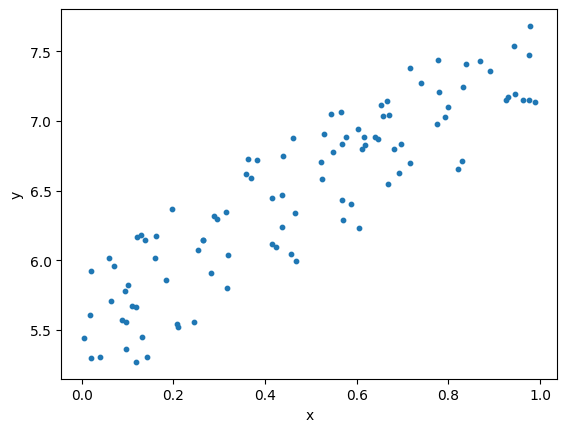

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(x, y, s=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### 7.2.2 線形回帰の理論

回帰直線 $y=Wx+b$

残差 $Wx_i+b-y_i$

平均2乗誤差 $\displaystyle L=\frac{1}{N}\sum_{i=1}^{N}(Wx_i+b-y_i)^2$

#### 7.2.3 線形回帰の実装

In [ ]:
import numpy as np
from dezero import Variable
import dezero.functions as F

# トイ・データセット
np.random.seed(0)
x = np.random.rand(100, 1)
y = 5 + 2 * x + np.random.rand(100, 1)
x, y = Variable(x), Variable(y)  # 省略可能

W = Variable(np.zeros((1, 1)))
b = Variable(np.zeros(1))

def predict(x):
    y = F.matmul(x, W) + b
    return y

`x` の shape が `(100, 1)` で `W` の shape が `(1, 1)` なら `F.matmul(x, W)` の shape は `(100, 1)` になる。

`b` の shape は `(1,)` だが shape `(100, 1)` と shape `(1,)` の足し算は可能。型の自動変換（ブロードキャスト）によって大きい方に揃えられる。

In [ ]:
def mean_squared_error(x0, x1):
    diff = x0 - x1
    return F.sum(diff ** 2) / len(diff)

lr = 0.1
iters = 100

for i in range(iters):
    y_pred = predict(x)
    loss = mean_squared_error(y, y_pred)

    W.cleargrad()
    b.cleargrad()
    loss.backward()

    W.data -= lr * W.grad.data
    b.data -= lr * b.grad.data

    if i % 10 == 0:
        print(loss.data)

print('====')
print('W =', W.data)
print('b =', b.data)

42.296340129442335
0.24915731977561134
0.10078974954301652
0.09461859803040694
0.0902667138137311
0.08694585483964615
0.08441084206493275
0.08247571022229121
0.08099850454041051
0.07987086218625004
====
W = [[2.11807369]]
b = [5.46608905]


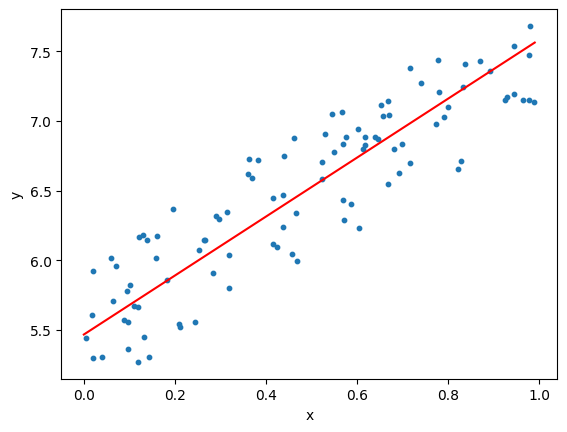

In [ ]:
import matplotlib.pyplot as plt

# Plot
plt.scatter(x.data, y.data, s=10)
plt.xlabel('x')
plt.ylabel('y')
t = np.arange(0, 1, .01)[:, np.newaxis]
y_pred = predict(t)
plt.plot(t, y_pred.data, color='r')
plt.show()

### 7.3 ニューラルネットワーク

#### 7.3.1 非線形なデータセット

In [ ]:
# より複雑なデータセット

import numpy as np

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

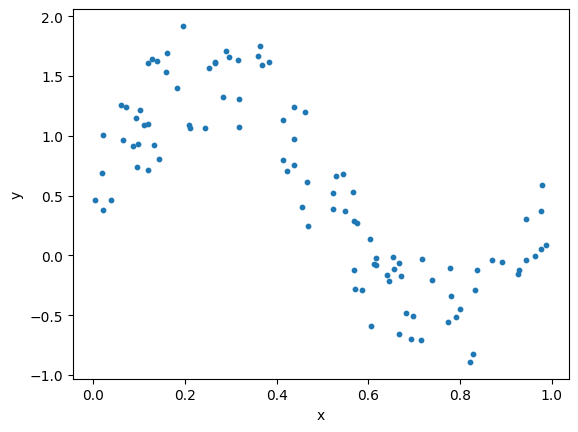

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(x, y, s=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

線形回帰では対応できそうにない。

実際に試すと以下のようになる。

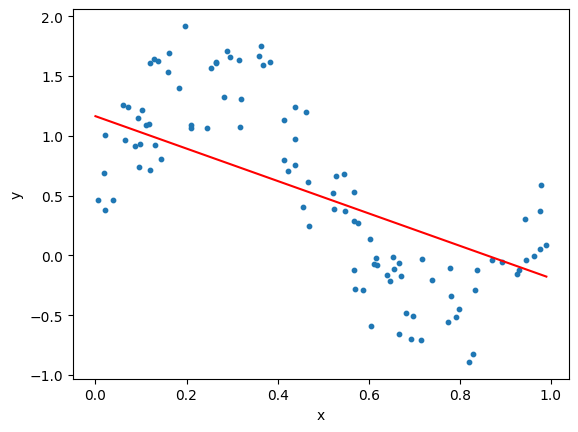

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import dezero.functions as F


W = Variable(np.zeros((1, 1)))
b = Variable(np.zeros(1))

def predict(x):
    y = F.matmul(x, W) + b
    return y

lr = 0.1
iters = 100

for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)

    W.cleargrad()
    b.cleargrad()
    loss.backward()

    W.data -= lr * W.grad.data
    b.data -= lr * b.grad.data

    #if i % 10 == 0:
    #    print(loss.data)

#print('====')
#print('W =', W.data)
#print('b =', b.data)

plt.scatter(x, y, s=10)
plt.xlabel('x')
plt.ylabel('y')
t = np.arange(0, 1, .01)[:, np.newaxis]
y_pred = predict(t)
plt.plot(t, y_pred.data, color='r')
plt.show()

そこで，ニューラルネットワークをつかう。

#### 7.3.2 線形変換と活性化関数

In [ ]:
# 線形変換

import numpy as np
from dezero import Variable
import dezero.functions as F

np.random.seed(0)
x = np.random.rand(100, 1)
x = Variable(x)  # 省略可能

W = Variable(np.zeros((1, 1)))
b = Variable(np.zeros(1))

# 線形変換（その1）
y1 = F.matmul(x, W) + b

# 線形変換（その2）
y2 = F.linear(x, W, b)

線型変換とは `F.matmul(x, W) + b` のようなもの。

`F.linear(x, W, b)` と書くこともできる。

ニューラルネットワークでは，線形変換の出力に対して非線型な変換を用いる。たとえばシグモイド関数や，ReLU 関数など。一定の閾値を越えると値が一気に増えるなど関数の様子がガラッと変わる点が非線型変換の特徴である。ニューラルネットワークの文脈では，そのような非線型変換のことを活性化関数とよぶ。

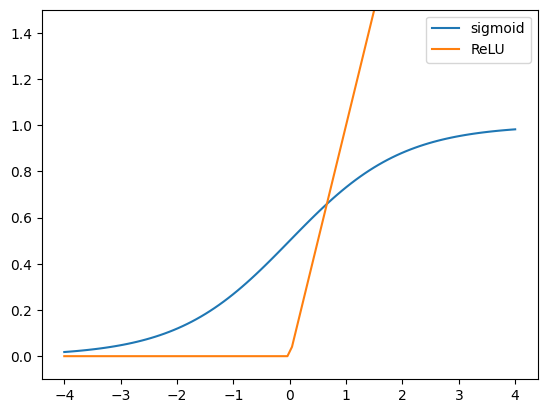

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import dezero.functions as F

x = np.linspace(-4, 4, 100)
y = F.sigmoid(x)
plt.plot(x, y.data, label='sigmoid')
y = F.relu(x)
plt.plot(x, y.data, label='ReLU')
plt.legend()
plt.ylim(-0.1, 1.5)
plt.show()

#### 7.3.3 ニューラルネットワークの実装

一般的なニューラルネットワークは「線形変換」と「活性化関数」を交互に使用する。

In [ ]:
# W1, b1 = Variable(...), Variable(...)
# W2, b2 = Variable(...), Variable(...)

def predict(x):
    y = F.linear(x, W1, b1)
    y = F.sigmoid(y)
    y = F.linear(y, W2, b2)
    return y

In [ ]:
import numpy as np
from dezero import Variable
import dezero.functions as F

# データセット
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

# ①重みの初期化
I, H, O = 1, 10, 1
W1 = Variable(0.01 * np.random.randn(I, H))
b1 = Variable(np.zeros(H))
W2 = Variable(0.01 * np.random.randn(H, O))
b2 = Variable(np.zeros(O))

# ②ニューラルネットワークの推論
def predict(x):
    y = F.linear(x, W1, b1)
    y = F.sigmoid(y)
    y = F.linear(y, W2, b2)
    return y

lr = 0.2
iters = 10000

# ③ニューラルネットワークの学習
for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)

    W1.cleargrad()
    b1.cleargrad()
    W2.cleargrad()
    b2.cleargrad()

    loss.backward()

    W1.data -= lr * W1.grad.data
    b1.data -= lr * b1.grad.data
    W2.data -= lr * W2.grad.data
    b2.data -= lr * b2.grad.data
    if i % 1000 == 0: # 1000回ごとに出力
        print(loss.data)

0.8473695850105871
0.2514286285183606
0.24759485466749873
0.23786120447054818
0.21222231333102928
0.1674218111783415
0.09681932619992643
0.07849528290602327
0.07749729552991155
0.07722132399559314


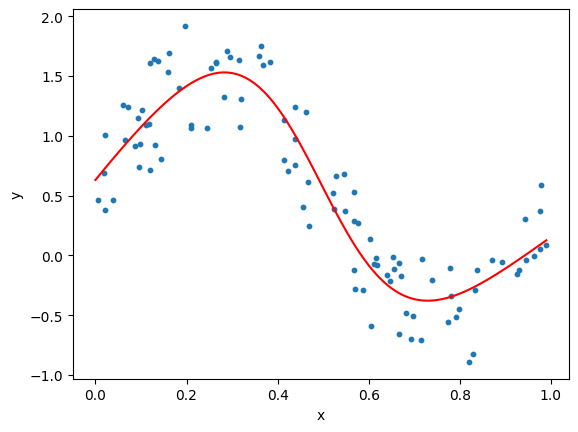

In [ ]:
import matplotlib.pyplot as plt

# Plot
plt.scatter(x, y, s=10)
plt.xlabel('x')
plt.ylabel('y')
t = np.arange(0, 1, .01)[:, np.newaxis]
y_pred = predict(t)
plt.plot(t, y_pred.data, color='r')
plt.show()

線形変換だけを使ったときと比べて，うまくいったように見える。

#### 7.3.4 レイヤとモデル

In [ ]:
import dezero.layers as L

help(L.Linear)

Help on class Linear in module dezero.layers:

class Linear(Layer)
 |  Linear(out_size, nobias=False, dtype=<class 'numpy.float32'>, in_size=None)
 |  
 |  # =============================================================================
 |  # Linear / Conv2d / Deconv2d
 |  # =============================================================================
 |  
 |  Method resolution order:
 |      Linear
 |      Layer
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, out_size, nobias=False, dtype=<class 'numpy.float32'>, in_size=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  forward(self, x)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from Layer:
 |  
 |  __call__(self, *inputs)
 |      Call self as a function.
 |  
 |  __setattr__(self, name, value)
 |      Implement setattr(self, name, value).
 |  
 |  cleargrads(self)
 |  
 |  load_weights(self, path)
 |  
 |  para

Linear レイヤの引数
- `out_size` は出力サイズ（出力データの次元数）
- `nobias` はバイアスを使用するかどうかのフラグ
  - デフォルトでは `False` つまりバイアスあり
- `dtype` はデータ型
  - デフォルトでは 32 ビット浮動小数点数
- `in_size` は入力サイズ（入力データの次元数）
  - 入力サイズが None のときは，データを流すときに入力サイズを自動検知してくれるらしい

Linear レイヤを使う例

In [ ]:
import numpy as np
import dezero.layers as L

linear = L.Linear(10)  # 出力サイズだけを指定

batch_size, input_size = 100, 5
x = np.random.randn(batch_size, input_size)
y = linear(x)

print('y shape:', y.shape)
print('params shape:', linear.W.shape, linear.b.shape)

for param in linear.params():
    print(param.name, param.shape)

y shape: (100, 10)
params shape: (5, 10) (10,)
b (10,)
W (5, 10)


1つのクラスとしてニューラルネットワークを定義する例

In [ ]:
from dezero import Model
import dezero.layers as L
import dezero.functions as F

class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x):
        y = F.relu(self.l1(x))
        y = self.l2(y)
        return y

In [ ]:
model = TwoLayerNet(10, 1)

# すべてのパラメータにアクセス
for param in model.params():
    print(param)

# すべてのパラメータの勾配をリセット
model.cleargrads()

variable([0.])
variable(None)
variable([0. 0. 0. 0. 0. 0. 0. 0. 0. 0.])
variable(None)


sin 関数の非線形データの学習を， dezero.Model と dezero.layers を使って行う

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dezero import Model
import dezero.layers as L
import dezero.functions as F

# Dataset
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2
iters = 10000

class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y

model = TwoLayerNet(10, 1)

for i in range(iters):
    y_pred = model.forward(x)  # もしくは model(x) でも同じ動作
    loss = F.mean_squared_error(y, y_pred)

    model.cleargrads()
    loss.backward()

    for p in model.params():
        p.data -= lr * p.grad.data

    if i % 1000 == 0:
        print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.12311905720649353)
variable(0.07888166506355149)
variable(0.07655073683421637)
variable(0.0763780308623822)
variable(0.07618764131185571)


#### 7.3.5 オプティマイザ（最適化手法）

In [ ]:
import numpy as np
from dezero import Model
from dezero import optimizers
import dezero.layers as L
import dezero.functions as F

# Dataset
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2
iters = 10000

class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y

model = TwoLayerNet(10, 1)
optimizer = optimizers.SGD(lr)  # オプティマイザの生成
optimizer.setup(model)

for i in range(iters):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)

    model.cleargrads()
    loss.backward()

    optimizer.update()  # オプティマイザによる更新
    if i % 1000 == 0:
        print(loss.data)

0.8165178492839196
0.24990280802148895
0.24609876581126014
0.2372159081431807
0.20793216413350174
0.12311905720649353
0.07888166506355149
0.07655073683421637
0.0763780308623822
0.07618764131185571


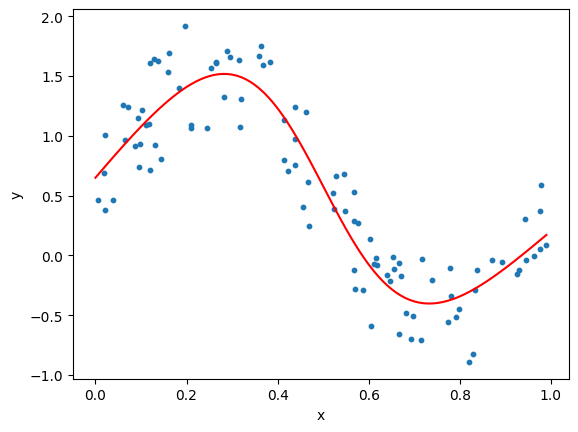

In [ ]:
import matplotlib.pyplot as plt

# Plot
plt.scatter(x, y, s=10)
plt.xlabel('x')
plt.ylabel('y')
t = np.arange(0, 1, .01)[:, np.newaxis]
y_pred = model(t)
plt.plot(t, y_pred.data, color='r')
plt.show()

ここでは SGD（Stochastic Gradient Descent; 確率的勾配降下法）を用いた。

他にも

- Momentum
- AdaGrad
- AdaDelta
- Adam

等がある。

In [ ]:
dir(optimizers)

['AdaDelta',
 'AdaGrad',
 'Adam',
 'ClipGrad',
 'FreezeParam',
 'MomentumSGD',
 'Optimizer',
 'Parameter',
 'SGD',
 'WeightDecay',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'cuda',
 'math']

### 7.4 Q学習とニューラルネットワーク

#### 7.4.1 ニューラルネットワークの前処理

カテゴリデータを one-hot ベクトルに変換する。

たとえば，「3 x 4 のグリッドワールド」における状態を one-hot ベクトルへ変換する。

In [ ]:
import numpy as np

def one_hot(state):
    HEIGHT, WIDTH = 3, 4
    vec = np.zeros(HEIGHT * WIDTH, dtype=np.float32)
    y, x = state
    idx = WIDTH * y + x
    vec[idx] = 1.0
    return vec[np.newaxis, :]  # バッチのための新しい軸を追加

state = (2, 0)
x = one_hot(state)

print(x.shape)  # (1, 12)
print(x)  # [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

(1, 12)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


#### 7.4.2 Q関数を表すニューラルネットワーク

これまでは Q 関数をテーブルとして実装した。たとえば

In [ ]:
from collections import defaultdict

Q = defaultdict(lambda: 0)
state = (2, 0)
action = 0

print(Q[state, action])  # 0.0

0


この Q 関数は (state, action) というペアを入力として，1 つのスカラ値を返す。

一方で， state を入力として action の個数だけ Q 関数の値を返すようにして，その最大値をとるような NN レイヤを考えることもできる。

NN の場合，後者であれば1度の順伝播によってすべての action に対する Q 関数の値を求めることができ，効率が良い。


In [ ]:
from dezero import Model
import dezero.functions as F
import dezero.layers as L

class QNet(Model):
    def __init__(self):
        super().__init__()
        self.l1 = L.Linear(100)  # 中間層のサイズ
        self.l2 = L.Linear(4)    # 行動のサイズ

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

qnet = QNet()

state = (2, 0)
state = one_hot(state)

qs = qnet(state)
print(qs.shape)

(1, 4)


#### 7.4.3 ニューラルネットワークとQ学習

Q 関数の復習

$$
Q'(S_t,A_t)
=
Q(S_t,A_t)
+
\alpha
\Bigl\{
  R_t
  +
  \gamma
  \max_a Q(S_{t+1},a)
  -
  Q(S_t,A_t)
\Bigr\}
$$

ターゲット $\displaystyle R_t+\gamma \max_a Q(S_{t+1},a)$ を $T$ とおくと

$$
Q'(S_t,A_t) = Q(S_t,A_t) + \alpha \Bigl\{ T - Q(S_t,A_t) \Bigr\}
$$

入力 $(S_t,A_t)$ に対する出力が $T$ になるように学習している，ととらえることができる。

In [ ]:
# Q学習エージェント
# ch07/q_learning_nn.py
# ch06/q_learning_simple.py と比較してみると良い

class QLearningAgent:
    def __init__(self):
        self.gamma = 0.9
        self.lr = 0.01
        self.epsilon = 0.1
        self.action_size = 4

        self.qnet = QNet()
        self.optimizer = optimizers.SGD(self.lr)
        self.optimizer.setup(self.qnet)

    # ε-greedy によって行動を選択する
    # state は one-hot ベクトル
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            qs = self.qnet(state)
            return qs.data.argmax()

    # Q 関数を更新する
    def update(self, state, action, reward, next_state, done):
        if done:
            next_q = np.zeros(1)  # [0.]
        else:
            next_qs = self.qnet(next_state)
            next_q = next_qs.max(axis=1)
            next_q.unchain()  # バックプロパゲーションの対象から除外する

        target = self.gamma * next_q + reward
        qs = self.qnet(state)
        q = qs[:, action]
        loss = F.mean_squared_error(target, q)

        # バックプロパゲーション
        self.qnet.cleargrads()
        loss.backward()
        self.optimizer.update()

        return loss.data

In [ ]:
### 以下のコードを if 文を使わずに書き直すことができる

if done:
    next_q = np.zeros(1)  # [0.]
else:
    next_qs = self.qnet(next_state)
    next_q = next_qs.max(axis=1)
    next_q.unchain()

### 以下のコードを if 文を使わずに書き直すことができる

next_qs = self.qnet(next_state)
next_q = next_qs.max(axis=1)
next_q.unchain()
next_q *= (1 - done)


NameError: ignored

エージェントの実行例

In [ ]:
# ch07/q_learning_nn.py

from dezerogym.gridworld import GridWorld

env = GridWorld()
agent = QLearningAgent()

episodes = 1000
loss_history = []

for episode in range(episodes):
    state = env.reset()
    state = one_hot(state)
    total_loss, cnt = 0, 0
    done = False

    while not done:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        next_state = one_hot(next_state)

        loss = agent.update(state, action, reward, next_state, done)
        total_loss += loss
        cnt += 1
        state = next_state

    average_loss = total_loss / cnt
    loss_history.append(average_loss)

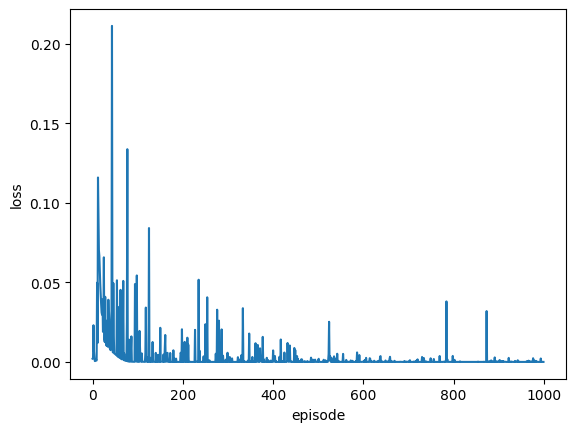

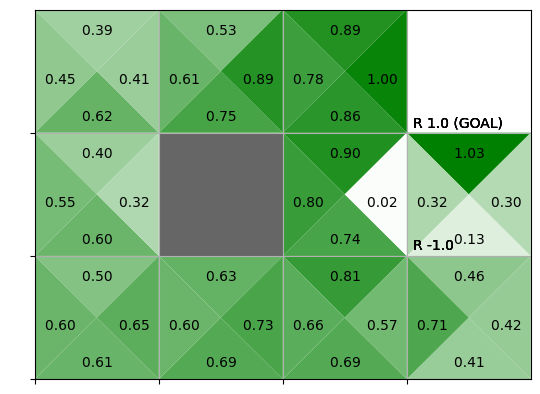

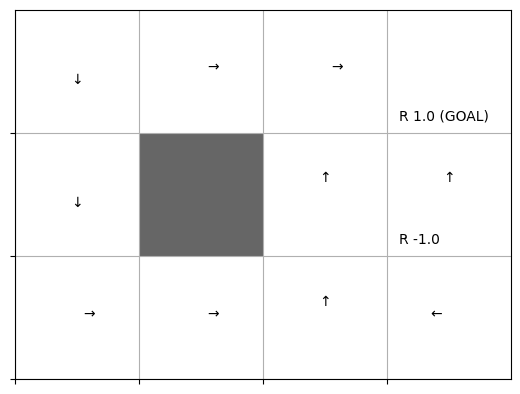

In [ ]:
plt.xlabel('episode')
plt.ylabel('loss')
plt.plot(range(len(loss_history)), loss_history)
plt.show()

# visualize
Q = {}
for state in env.states():
    for action in env.action_space:
        q = agent.qnet(one_hot(state))[:, action]
        Q[state, action] = float(q.data)
env.render_q(Q)

### 7.5 まとめ

- DeZero の使い方
- DeZero で線形回帰
- DeZero でニューラルネットワーク
- ニューラルネットワークを使った Q 学習